In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class CIFAR100CNN(nn.Module):
    def __init__(self, dropout_rate=0.2):  # Reduced dropout rate
        super(CIFAR100CNN, self).__init__()
        
        self.dropout1 = nn.Dropout2d(dropout_rate)
        self.dropout2 = nn.Dropout2d(dropout_rate)
        self.dropout3 = nn.Dropout2d(dropout_rate)
        self.dropout4 = nn.Dropout2d(dropout_rate)
        self.dropout5 = nn.Dropout2d(dropout_rate)
        self.fc_dropout = nn.Dropout(dropout_rate)
        
        # Added an additional convolutional block and adjusted channels
        self.conv_layers = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Second block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Third block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # Fourth block (new)
            nn.Conv2d(128, 192, kernel_size=3, padding=1),
            nn.BatchNorm2d(192),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Fifth block
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(),
            nn.Linear(512, 256),  # Additional FC layer
            nn.ReLU(),
            nn.Linear(256, 100)
        )
    
    def forward(self, x):
        # First conv block
        x = self.conv_layers[0:4](x)
        x = self.dropout1(x)
        
        # Second conv block
        x = self.conv_layers[4:8](x)
        x = self.dropout2(x)
        
        # Third conv block
        x = self.conv_layers[8:11](x)
        x = self.dropout3(x)
        
        # Fourth conv block
        x = self.conv_layers[11:15](x)
        x = self.dropout4(x)
        
        # Fifth conv block
        x = self.conv_layers[15:](x)
        x = self.dropout5(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc_layers[0:2](x)
        x = self.fc_dropout(x)
        x = self.fc_layers[2:](x)
        return x

In [3]:
train_set = torch.load("train.pt")
valid_set = torch.load("valid.pt")

batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=8, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size, shuffle=False, num_workers=8, pin_memory=True)

C:\Users\swing\AppData\Local\Temp\ipykernel_24676\514439394.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_set = torch.load("train.pt")
C:\Users\swing\AppData\Loc

In [4]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(train_loader)
    return accuracy, avg_loss

In [5]:
def validate(model, valid_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valid_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = running_loss / len(valid_loader)
    return accuracy, avg_loss

In [6]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = CIFAR100CNN().to(DEVICE)

In [7]:
epochs = 150
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=100,
)

In [8]:
def train_model(model, criterion, optimizer, scheduler, epochs, path='model.pth'):

    torch.backends.cudnn.benchmark = True

    best_acc = 0
    patience = 10
    patience_cnt = 0

    for epoch in range(epochs):
        train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler, DEVICE)
        valid_acc, valid_loss = validate(model, valid_loader, criterion, DEVICE)
        
        # Save best model
        if valid_acc > best_acc:
            best_acc = valid_acc
            patience_cnt = 0
            torch.save(model, path)
            print(f'Best model saved! Accuracy: {best_acc:.2f}%')
        else:
            patience_cnt = patience_cnt + 1
            if patience_cnt >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        current_lr = scheduler.get_last_lr()[0]
        print(f'Epoch: {epoch+1}/{epochs} (Learning Rate: {current_lr:.6f})')
        print(f'Train Acc: {train_acc:.2f}% | Train Loss: {train_loss:.4f}')
        print(f'Valid Acc: {valid_acc:.2f}% | Valid Loss: {valid_loss:.4f}')
        print('-' * 50)

In [37]:
train_model(cnn, criterion, optimizer, scheduler, epochs, 'cnn.pth')

Best model saved! Accuracy: 4.53%
Epoch: 1/150 (Learning Rate: 0.000053)
Train Acc: 2.30% | Train Loss: 4.5170
Valid Acc: 4.53% | Valid Loss: 4.3594
--------------------------------------------------
Best model saved! Accuracy: 7.52%
Epoch: 2/150 (Learning Rate: 0.000060)
Train Acc: 5.84% | Train Loss: 4.1974
Valid Acc: 7.52% | Valid Loss: 4.0836
--------------------------------------------------
Best model saved! Accuracy: 11.11%
Epoch: 3/150 (Learning Rate: 0.000073)
Train Acc: 9.00% | Train Loss: 3.9660
Valid Acc: 11.11% | Valid Loss: 3.8670
--------------------------------------------------
Best model saved! Accuracy: 15.36%
Epoch: 4/150 (Learning Rate: 0.000091)
Train Acc: 11.75% | Train Loss: 3.7842
Valid Acc: 15.36% | Valid Loss: 3.6243
--------------------------------------------------
Best model saved! Accuracy: 17.07%
Epoch: 5/150 (Learning Rate: 0.000114)
Train Acc: 14.13% | Train Loss: 3.6267
Valid Acc: 17.07% | Valid Loss: 3.4732
-------------------------------------------

In [ ]:
class CNNTransformer(nn.Module):
    def __init__(self, d_model=256, nhead=8, num_layers=2, dropout_rate=0.3):
        super(CNNTransformer, self).__init__()
        
        # First two conv layers remain same
        self.conv_layers1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.MaxPool2d(2),
        )
        
        # Transform features for transformer
        self.conv_to_seq = nn.Conv2d(64, d_model, kernel_size=1)
        
        # Transformer layer
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=512, dropout=dropout_rate)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Final conv layer
        self.conv_layers2 = nn.Sequential(
            nn.Conv2d(d_model, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(dropout_rate),
            nn.MaxPool2d(2)
        )
        
        # Fully connected layers
        self.fc_layers = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 100)
        )
        
    def forward(self, x):
        # Initial conv layers
        x = self.conv_layers1(x)  # Output: [batch, 64, 8, 8]
        
        # Prepare for transformer
        x = self.conv_to_seq(x)  # Output: [batch, d_model, 8, 8]
        
        # Reshape for transformer: [batch, seq_len, d_model]
        batch_size = x.size(0)
        x = x.flatten(2).permute(2, 0, 1)  # [64, batch, d_model]
        
        # Apply transformer
        x = self.transformer(x)
        
        # Reshape back: [batch, d_model, 8, 8]
        x = x.permute(1, 2, 0).view(batch_size, -1, 8, 8)
        
        # Final conv and fc layers
        x = self.conv_layers2(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [ ]:
cnn_transformer = CNNTransformer().to(DEVICE)

c:\Users\swing\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [ ]:
epochs = 150
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_transformer.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=100,
)

In [ ]:
train_model(cnn_transformer, criterion, optimizer, scheduler, epochs, 'cnn_transformer.pth')

c:\Users\swing\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Best model saved! Accuracy: 9.34%
Epoch: 1/150 (Learning Rate: 0.000053)
Train Acc: 3.46% | Train Loss: 4.4327
Valid Acc: 9.34% | Valid Loss: 4.0023
--------------------------------------------------
Best model saved! Accuracy: 14.95%
Epoch: 2/150 (Learning Rate: 0.000060)
Train Acc: 8.01% | Train Loss: 4.0627
Valid Acc: 14.95% | Valid Loss: 3.6796
--------------------------------------------------
Best model saved! Accuracy: 19.33%
Epoch: 3/150 (Learning Rate: 0.000073)
Train Acc: 12.19% | Train Loss: 3.7966
Valid Acc: 19.33% | Valid Loss: 3.3952
--------------------------------------------------
Best model saved! Accuracy: 23.70%
Epoch: 4/150 (Learning Rate: 0.000091)
Train Acc: 15.66% | Train Loss: 3.5795
Valid Acc: 23.70% | Valid Loss: 3.1867
--------------------------------------------------
Best model saved! Accuracy: 26.43%
Epoch: 5/150 (Learning Rate: 0.000114)
Train Acc: 18.87% | Train Loss: 3.3952
Valid Acc: 26.43% | Valid Loss: 3.0333
----------------------------------------

In [18]:
def random_patch_drop(images, drop_ratio=0.5, patch_size=4):
    """
    Randomly drops patches from images by setting them to zero.
    
    Args:
        images: Tensor of shape [batch_size, channels, height, width]
        drop_ratio: Fraction of patches to drop (between 0 and 1)
        patch_size: Size of each patch (default 16 for ViT)
        
    Returns:
        Tensor of same shape as input with random patches set to zero
    """
    b, c, h, w = images.shape
    
    # Calculate number of patches
    n_patches_h = h // patch_size
    n_patches_w = w // patch_size
    total_patches = n_patches_h * n_patches_w
    
    # Calculate number of patches to drop
    n_drop = int(total_patches * drop_ratio)
    
    # Initialize mask for all patches (1 = keep, 0 = drop)
    mask = torch.ones((b, 1, n_patches_h, n_patches_w), device=images.device)
    
    # For each image in batch
    for i in range(b):
        # Randomly select patches to drop
        drop_indices = random.sample(range(total_patches), n_drop)
        
        # Convert to 2D indices
        drop_h = [idx // n_patches_w for idx in drop_indices]
        drop_w = [idx % n_patches_w for idx in drop_indices]
        
        # Set selected patches to 0 in mask
        mask[i, 0, drop_h, drop_w] = 0
    
    # Upsample mask to image size
    mask = F.interpolate(mask, size=(h, w), mode='nearest')
    
    # Apply mask to image
    return images * mask

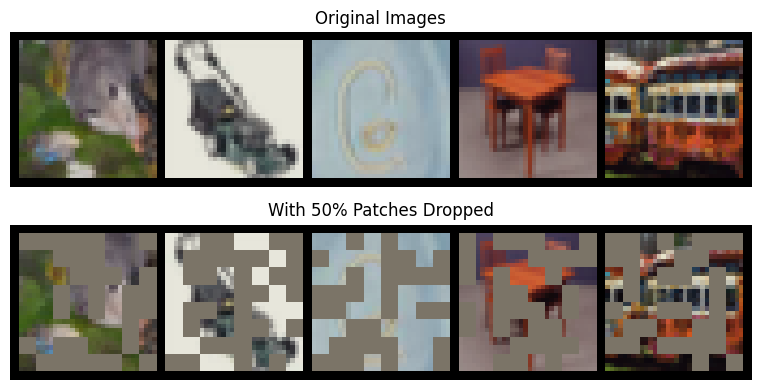

In [19]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import random

def create_patch_drop_grid(images, drop_ratio=0.5, num_examples=5):
    """Create a grid showing multiple images with patch dropping"""
    originals = []
    dropped = []
    
    # Convert tensor to range [0,1] for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(images.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(images.device)
    
    for i in range(num_examples):
        img = images[i:i+1]
        # Denormalize
        orig = img * std + mean
        drop = random_patch_drop(img, drop_ratio=drop_ratio) * std + mean
        
        originals.append(orig[0])
        dropped.append(drop[0])
    
    # Create comparison grid
    plt.figure(figsize=(15, 4))
    
    # Show originals
    plt.subplot(2, 1, 1)
    grid = make_grid(originals, nrow=num_examples, padding=2, normalize=False)
    plt.imshow(grid.cpu().permute(1, 2, 0).clamp(0, 1))
    plt.title("Original Images")
    plt.axis('off')
    
    # Show dropped versions
    plt.subplot(2, 1, 2)
    grid = make_grid(dropped, nrow=num_examples, padding=2, normalize=False)
    plt.imshow(grid.cpu().permute(1, 2, 0).clamp(0, 1))
    plt.title(f"With {drop_ratio*100:.0f}% Patches Dropped")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Show grid of examples
images, labels = next(iter(valid_loader))
images = images.to(DEVICE)

create_patch_drop_grid(images, drop_ratio=0.5)

In [20]:
import tqdm

def evaluate_with_patch_drop(model, val_loader, device, drop_ratios=[0.0, 0.2, 0.4, 0.6, 0.8]):
    """
    Evaluate model accuracy with different patch drop ratios
    """
    model.eval()
    results = {}
    
    for drop_ratio in drop_ratios:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                
                # Apply patch drop
                if drop_ratio > 0:
                    images = random_patch_drop(images, drop_ratio=drop_ratio)
                
                outputs = model(images)

                if isinstance(outputs, (list, tuple)):
                    outputs = outputs[-1] 
                
                _, predicted = outputs.max(1)
                
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        accuracy = 100 * correct / total
        results[drop_ratio] = accuracy
        print(f"Drop ratio: {drop_ratio:.2f}, Accuracy: {accuracy:.2f}%")
        
    plt.figure(figsize=(10, 6))
    plt.plot(list(results.keys()), list(results.values()), marker='o')
    plt.xlabel('Drop Ratio')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy vs Patch Drop Ratio')
    plt.grid(True)
    plt.show()

In [21]:
def compare_models_patch_drop(models, names, val_loader, device, drop_ratios=[0.0, 0.2, 0.4, 0.6, 0.8]):
    """
    Compare multiple models' accuracy with different patch drop ratios
    """
    plt.figure(figsize=(10, 6))
    
    for model, name in zip(models, names):
        model.eval()
        results = {}
        
        for drop_ratio in drop_ratios:
            correct = 0
            total = 0
            
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    
                    if drop_ratio > 0:
                        images = random_patch_drop(images, drop_ratio=drop_ratio)
                    
                    outputs = model(images)
                    if isinstance(outputs, (list, tuple)):
                        outputs = outputs[-1]
                    
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels).sum().item()
            
            accuracy = 100 * correct / total
            results[drop_ratio] = accuracy
            print(f"{name} - Drop ratio: {drop_ratio:.2f}, Accuracy: {accuracy:.2f}%")
        
        plt.plot(list(results.keys()), list(results.values()), marker='o', label=name)
    
    plt.xlabel('Drop Ratio')
    plt.ylabel('Accuracy (%)')
    plt.title('Model Accuracy vs Patch Drop Ratio')
    plt.legend()
    plt.grid(True)
    plt.show()

CNN - Drop ratio: 0.00, Accuracy: 89.87%
CNN - Drop ratio: 0.05, Accuracy: 82.99%
CNN - Drop ratio: 0.10, Accuracy: 71.18%
CNN - Drop ratio: 0.15, Accuracy: 59.76%
CNN - Drop ratio: 0.20, Accuracy: 49.04%
CNN - Drop ratio: 0.25, Accuracy: 36.80%
CNN - Drop ratio: 0.30, Accuracy: 30.10%
CNN - Drop ratio: 0.35, Accuracy: 23.56%
CNN - Drop ratio: 0.40, Accuracy: 19.09%
CNN - Drop ratio: 0.45, Accuracy: 15.88%
CNN - Drop ratio: 0.50, Accuracy: 11.61%
CNN - Drop ratio: 0.55, Accuracy: 9.16%
CNN - Drop ratio: 0.60, Accuracy: 7.42%
CNN - Drop ratio: 0.65, Accuracy: 6.10%
CNN - Drop ratio: 0.70, Accuracy: 4.57%
CNN - Drop ratio: 0.75, Accuracy: 3.80%
CNN - Drop ratio: 0.80, Accuracy: 3.27%
CNN - Drop ratio: 0.85, Accuracy: 2.30%
CNN - Drop ratio: 0.90, Accuracy: 1.96%
CNN - Drop ratio: 0.95, Accuracy: 1.60%
CNN - Drop ratio: 1.00, Accuracy: 0.99%
CNN_Transformer - Drop ratio: 0.00, Accuracy: 89.55%
CNN_Transformer - Drop ratio: 0.05, Accuracy: 85.26%
CNN_Transformer - Drop ratio: 0.10, Accurac

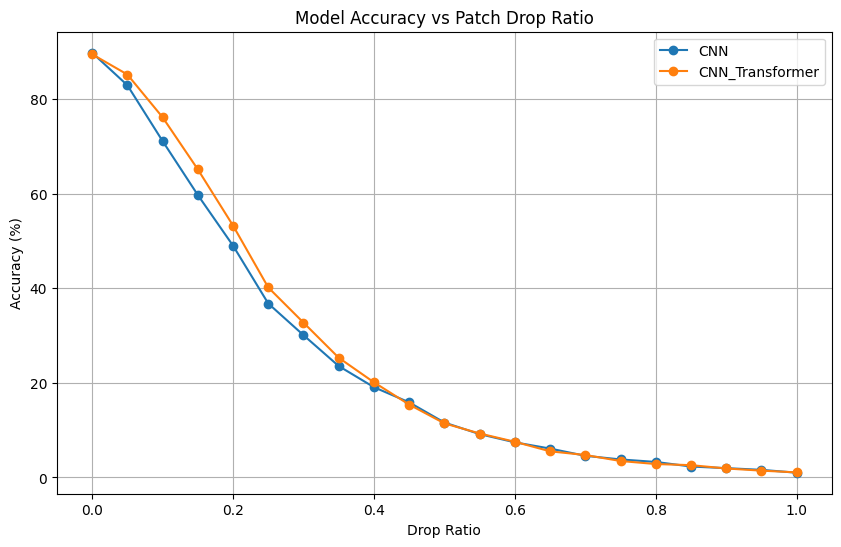

In [38]:
drop_ratios = [round(x * 0.05, 2) for x in range(0, 21)]
compare_models_patch_drop([cnn, cnn_transformer], ['CNN', 'CNN_Transformer'], valid_loader, DEVICE, drop_ratios)

In [42]:
class ModifiedCNN(nn.Module):
    def __init__(self, embed_dim=256, dropout_rate=0.2):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.dropout = nn.Dropout2d(dropout_rate)
        self.fc_dropout = nn.Dropout(dropout_rate)
        
        # Feature extraction
        self.conv_stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            self.dropout,
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            self.dropout
        )
        
        # Main backbone (matching transformer blocks)
        self.backbone = nn.Sequential(
            nn.Conv2d(64, embed_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            self.dropout,
            
            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.MaxPool2d(2),
            self.dropout
        )
        
        # Feature projection
        self.projection = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            self.dropout
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 2 * 2, 512),
            nn.ReLU(),
            self.fc_dropout,
            nn.Linear(512, 100)
        )
    
    def forward(self, x):
        x = self.conv_stem(x)
        x = self.backbone(x)
        x = self.projection(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

class ModifiedTransformer(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, num_layers=2, dropout_rate=0.2):
        super().__init__()
        
        self.embed_dim = embed_dim
        self.dropout = nn.Dropout2d(dropout_rate)
        
        # Feature extraction (same as CNN)
        self.conv_stem = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            self.dropout,
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            self.dropout
        )
        
        # Patch embedding
        self.patch_embed = nn.Sequential(
            nn.Conv2d(64, embed_dim, kernel_size=1),
            nn.LayerNorm([embed_dim, 8, 8])
        )
        
        # Transformer blocks
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=512,
            dropout=dropout_rate,
            norm_first=True  # Pre-norm architecture
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Feature projection (same as CNN)
        self.projection = nn.Sequential(
            nn.Conv2d(embed_dim, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            self.dropout
        )
        
        self.fc = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 100)
        )
        
    def forward(self, x):
        # Shared stem
        x = self.conv_stem(x)
        
        # Patch embedding
        x = self.patch_embed(x)
        
        # Transformer
        b, c, h, w = x.shape
        x = x.flatten(2).permute(2, 0, 1)
        x = self.transformer(x)
        x = x.permute(1, 2, 0).view(b, c, h, w)
        
        # Shared projection and classification
        x = self.projection(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

In [47]:
modified_cnn = ModifiedCNN().to(DEVICE)

epochs = 150
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(modified_cnn.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=100,
)

train_model(modified_cnn, criterion, optimizer, scheduler, epochs, 'modified_cnn.pth')

Best model saved! Accuracy: 7.21%
Epoch: 1/150 (Learning Rate: 0.000053)
Train Acc: 3.50% | Train Loss: 4.4379
Valid Acc: 7.21% | Valid Loss: 4.2111
--------------------------------------------------
Best model saved! Accuracy: 11.97%
Epoch: 2/150 (Learning Rate: 0.000060)
Train Acc: 8.18% | Train Loss: 4.0562
Valid Acc: 11.97% | Valid Loss: 3.8649
--------------------------------------------------
Best model saved! Accuracy: 15.82%
Epoch: 3/150 (Learning Rate: 0.000073)
Train Acc: 12.03% | Train Loss: 3.7956
Valid Acc: 15.82% | Valid Loss: 3.5930
--------------------------------------------------
Best model saved! Accuracy: 20.52%
Epoch: 4/150 (Learning Rate: 0.000091)
Train Acc: 14.96% | Train Loss: 3.6027
Valid Acc: 20.52% | Valid Loss: 3.3657
--------------------------------------------------
Best model saved! Accuracy: 23.80%
Epoch: 5/150 (Learning Rate: 0.000114)
Train Acc: 17.73% | Train Loss: 3.4374
Valid Acc: 23.80% | Valid Loss: 3.1857
----------------------------------------

In [44]:
modified_transformer = ModifiedTransformer().to(DEVICE)

epochs = 150
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(modified_transformer.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=100,
)

train_model(modified_transformer, criterion, optimizer, scheduler, epochs, 'modified_transformer.pth')

Best model saved! Accuracy: 13.68%
Epoch: 1/150 (Learning Rate: 0.000053)
Train Acc: 5.54% | Train Loss: 4.2913
Valid Acc: 13.68% | Valid Loss: 3.7837
--------------------------------------------------
Best model saved! Accuracy: 19.89%
Epoch: 2/150 (Learning Rate: 0.000060)
Train Acc: 12.79% | Train Loss: 3.7872
Valid Acc: 19.89% | Valid Loss: 3.3788
--------------------------------------------------
Best model saved! Accuracy: 25.20%
Epoch: 3/150 (Learning Rate: 0.000073)
Train Acc: 17.04% | Train Loss: 3.4883
Valid Acc: 25.20% | Valid Loss: 3.1177
--------------------------------------------------
Best model saved! Accuracy: 27.82%
Epoch: 4/150 (Learning Rate: 0.000091)
Train Acc: 21.08% | Train Loss: 3.2748
Valid Acc: 27.82% | Valid Loss: 2.9696
--------------------------------------------------
Best model saved! Accuracy: 32.07%
Epoch: 5/150 (Learning Rate: 0.000114)
Train Acc: 24.96% | Train Loss: 3.0756
Valid Acc: 32.07% | Valid Loss: 2.7431
-------------------------------------

CNN - Drop ratio: 0.00, Accuracy: 90.11%
CNN - Drop ratio: 0.05, Accuracy: 84.33%
CNN - Drop ratio: 0.10, Accuracy: 74.78%
CNN - Drop ratio: 0.15, Accuracy: 61.95%
CNN - Drop ratio: 0.20, Accuracy: 51.60%
CNN - Drop ratio: 0.25, Accuracy: 39.24%
CNN - Drop ratio: 0.30, Accuracy: 31.20%
CNN - Drop ratio: 0.35, Accuracy: 25.50%
CNN - Drop ratio: 0.40, Accuracy: 20.35%
CNN - Drop ratio: 0.45, Accuracy: 15.64%
CNN - Drop ratio: 0.50, Accuracy: 12.24%
CNN - Drop ratio: 0.55, Accuracy: 9.95%
CNN - Drop ratio: 0.60, Accuracy: 8.05%
CNN - Drop ratio: 0.65, Accuracy: 6.44%
CNN - Drop ratio: 0.70, Accuracy: 4.91%
CNN - Drop ratio: 0.75, Accuracy: 3.57%
CNN - Drop ratio: 0.80, Accuracy: 3.60%
CNN - Drop ratio: 0.85, Accuracy: 2.18%
CNN - Drop ratio: 0.90, Accuracy: 2.03%
CNN - Drop ratio: 0.95, Accuracy: 1.89%
CNN - Drop ratio: 1.00, Accuracy: 0.99%
CNN_Transformer - Drop ratio: 0.00, Accuracy: 90.03%
CNN_Transformer - Drop ratio: 0.05, Accuracy: 84.92%
CNN_Transformer - Drop ratio: 0.10, Accurac

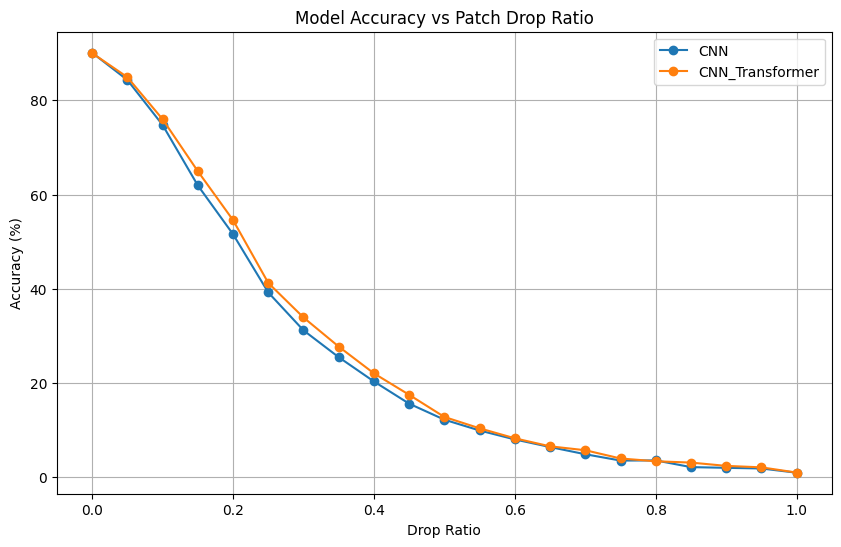

In [48]:
drop_ratios = [round(x * 0.05, 2) for x in range(0, 21)]
compare_models_patch_drop([modified_cnn, modified_transformer], ['CNN', 'CNN_Transformer'], valid_loader, DEVICE, drop_ratios)

In [56]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, dropout=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.dropout1 = nn.Dropout2d(dropout)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.dropout2 = nn.Dropout2d(dropout)
        
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride),
                nn.BatchNorm2d(out_channels)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.bn2(self.conv2(out))
        out = self.dropout2(out)
        out += self.skip(x)
        return F.relu(out)

class CIFAR100CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super().__init__()
        self.dropout = dropout
        # Initial conv layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout)
        )
        
        # Main blocks
        self.layer1 = self._make_layer(64, 128, stride=2)  # 16x16
        self.layer2 = self._make_layer(128, 256, stride=2)  # 8x8
        self.layer3 = self._make_layer(256, 512, stride=2)  # 4x4
        
        # Final classification
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout_fc = nn.Dropout(dropout)
        self.fc = nn.Linear(512, 100)
        
    def _make_layer(self, in_channels, out_channels, stride):
        layers = []
        layers.append(CNNBlock(in_channels, out_channels, stride, self.dropout))
        layers.append(CNNBlock(out_channels, out_channels, 1, self.dropout))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout_fc(x)
        x = self.fc(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout, batch_first=True)
        self.dropout1 = nn.Dropout(dropout)
        
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * mlp_ratio, dim),
            nn.Dropout(dropout)
        )
        
    def forward(self, x):
        # Attention block with dropout
        attn_out = self.attn(*[self.norm1(x)]*3)[0]
        x = x + self.dropout1(attn_out)
        
        # MLP block (dropout included in sequential)
        x = x + self.mlp(self.norm2(x))
        return x

class CIFAR100HybridTransformer(nn.Module):
    def __init__(self, embed_dim=256, dropout=0.3):
        super().__init__()
        # Convolutional feature extraction (similar to CNN initial layers)
        self.conv_features = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            CNNBlock(64, 128, stride=2, dropout=dropout),  # 16x16
            CNNBlock(128, embed_dim, stride=2, dropout=dropout)  # 8x8
        )
        
        # Prepare for transformer blocks
        self.patch_embed = nn.Conv2d(embed_dim, embed_dim, 2, 2)  # 4x4
        
        # Position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, 16, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim, dropout=dropout) for _ in range(6)
        ])
        
        # Final classification
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout_fc = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, 100)
        
    def forward(self, x):
        # Convolutional feature extraction
        x = self.conv_features(x)
        x = self.patch_embed(x)
        
        # Reshape for transformer: B, C, H, W -> B, HW, C
        x = x.flatten(2).transpose(1, 2)
        
        # Add position embeddings with dropout
        x = self.pos_drop(x + self.pos_embed)
        
        # Transformer blocks
        for block in self.transformer_blocks:
            x = block(x)
            
        # Classification
        x = self.norm(x.mean(1))  # Global average pooling
        x = self.dropout_fc(x)
        x = self.fc(x)
        return x

In [57]:
cnn_new = CIFAR100CNN().to(DEVICE)

epochs = 150
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn_new.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=100,
)

train_model(cnn_new, criterion, optimizer, scheduler, epochs, 'cnn_new.pth')

Best model saved! Accuracy: 5.09%
Epoch: 1/150 (Learning Rate: 0.000053)
Train Acc: 3.01% | Train Loss: 4.4711
Valid Acc: 5.09% | Valid Loss: 4.3138
--------------------------------------------------
Best model saved! Accuracy: 7.91%
Epoch: 2/150 (Learning Rate: 0.000060)
Train Acc: 6.25% | Train Loss: 4.1374
Valid Acc: 7.91% | Valid Loss: 4.0592
--------------------------------------------------
Best model saved! Accuracy: 10.43%
Epoch: 3/150 (Learning Rate: 0.000073)
Train Acc: 8.80% | Train Loss: 3.9486
Valid Acc: 10.43% | Valid Loss: 3.8690
--------------------------------------------------
Best model saved! Accuracy: 15.63%
Epoch: 4/150 (Learning Rate: 0.000091)
Train Acc: 11.86% | Train Loss: 3.7742
Valid Acc: 15.63% | Valid Loss: 3.5648
--------------------------------------------------
Best model saved! Accuracy: 19.22%
Epoch: 5/150 (Learning Rate: 0.000114)
Train Acc: 14.96% | Train Loss: 3.5863
Valid Acc: 19.22% | Valid Loss: 3.3639
-------------------------------------------

In [58]:
transformer_new = CIFAR100HybridTransformer().to(DEVICE)

epochs = 150
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(transformer_new.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=100,
)

train_model(transformer_new, criterion, optimizer, scheduler, epochs, 'transformer_new.pth')

Best model saved! Accuracy: 6.18%
Epoch: 1/150 (Learning Rate: 0.000053)
Train Acc: 3.60% | Train Loss: 4.4158
Valid Acc: 6.18% | Valid Loss: 4.1400
--------------------------------------------------
Best model saved! Accuracy: 9.30%
Epoch: 2/150 (Learning Rate: 0.000060)
Train Acc: 7.41% | Train Loss: 4.0635
Valid Acc: 9.30% | Valid Loss: 3.9380
--------------------------------------------------


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021DF30DEA60>
Traceback (most recent call last):
  File "c:\Users\swing\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "c:\Users\swing\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\dataloader.py", line 1435, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000021DF30DEA60>
Traceback (most recent call last):
  File "c:\Users\swing\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "c:\Users\swing\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\utils\data\dataloader.py

Best model saved! Accuracy: 10.87%
Epoch: 3/150 (Learning Rate: 0.000073)
Train Acc: 9.41% | Train Loss: 3.8979
Valid Acc: 10.87% | Valid Loss: 3.7999
--------------------------------------------------
Best model saved! Accuracy: 14.81%
Epoch: 4/150 (Learning Rate: 0.000091)
Train Acc: 11.31% | Train Loss: 3.7667
Valid Acc: 14.81% | Valid Loss: 3.5846
--------------------------------------------------
Best model saved! Accuracy: 16.67%
Epoch: 5/150 (Learning Rate: 0.000114)
Train Acc: 14.14% | Train Loss: 3.6188
Valid Acc: 16.67% | Valid Loss: 3.4592
--------------------------------------------------
Best model saved! Accuracy: 20.30%
Epoch: 6/150 (Learning Rate: 0.000141)
Train Acc: 16.55% | Train Loss: 3.4697
Valid Acc: 20.30% | Valid Loss: 3.2970
--------------------------------------------------
Best model saved! Accuracy: 22.92%
Epoch: 7/150 (Learning Rate: 0.000172)
Train Acc: 18.64% | Train Loss: 3.3444
Valid Acc: 22.92% | Valid Loss: 3.1672
-------------------------------------

CNN - Drop ratio: 0.00, Accuracy: 91.16%
CNN - Drop ratio: 0.05, Accuracy: 88.47%
CNN - Drop ratio: 0.10, Accuracy: 81.32%
CNN - Drop ratio: 0.15, Accuracy: 70.67%
CNN - Drop ratio: 0.20, Accuracy: 60.28%
CNN - Drop ratio: 0.25, Accuracy: 45.88%
CNN - Drop ratio: 0.30, Accuracy: 36.46%
CNN - Drop ratio: 0.35, Accuracy: 28.08%
CNN - Drop ratio: 0.40, Accuracy: 22.82%
CNN - Drop ratio: 0.45, Accuracy: 17.24%
CNN - Drop ratio: 0.50, Accuracy: 12.43%
CNN - Drop ratio: 0.55, Accuracy: 9.42%
CNN - Drop ratio: 0.60, Accuracy: 7.65%
CNN - Drop ratio: 0.65, Accuracy: 6.24%
CNN - Drop ratio: 0.70, Accuracy: 4.98%
CNN - Drop ratio: 0.75, Accuracy: 3.96%
CNN - Drop ratio: 0.80, Accuracy: 3.04%
CNN - Drop ratio: 0.85, Accuracy: 2.49%
CNN - Drop ratio: 0.90, Accuracy: 2.36%
CNN - Drop ratio: 0.95, Accuracy: 1.87%
CNN - Drop ratio: 1.00, Accuracy: 1.00%
CNN_Transformer - Drop ratio: 0.00, Accuracy: 91.13%
CNN_Transformer - Drop ratio: 0.05, Accuracy: 87.01%
CNN_Transformer - Drop ratio: 0.10, Accurac

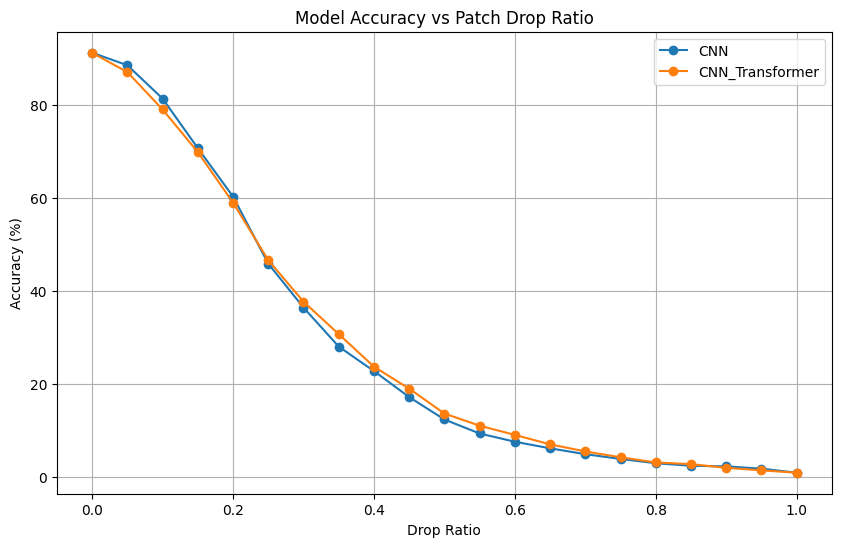

In [59]:
drop_ratios = [round(x * 0.05, 2) for x in range(0, 21)]
compare_models_patch_drop([cnn_new, transformer_new], ['CNN', 'CNN_Transformer'], valid_loader, DEVICE, drop_ratios)

In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, pool=True, dropout_rate=0.1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2) if pool else nn.Identity()
        self.dropout = nn.Dropout2d(dropout_rate)  # Added spatial dropout
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout(x)  # Dropout after first conv
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)  # Dropout after second conv
        return self.pool(x)

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=8, mlp_ratio=4, dropout_rate=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, dropout=dropout_rate)
        self.dropout1 = nn.Dropout(dropout_rate)  # Added dropout after attention
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * mlp_ratio),
            nn.GELU(),
            nn.Dropout(dropout_rate),  # Added dropout in MLP
            nn.Linear(dim * mlp_ratio, dim),
            nn.Dropout(dropout_rate)   # Added dropout after MLP
        )
        
    def forward(self, x):
        # x shape: (B, N, D) where N is sequence length
        attn_out = self._attention_block(self.norm1(x))
        x = x + self.dropout1(attn_out)  # Dropout after attention
        x = x + self.mlp(self.norm2(x))
        return x
    
    def _attention_block(self, x):
        x = x.transpose(0, 1)  # (N, B, D)
        x, _ = self.attn(x, x, x)
        return x.transpose(0, 1)  # (B, N, D)

class PureCNN(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        # Input: 32x32x3
        self.features = nn.Sequential(
            ConvBlock(3, 64, dropout_rate=0.1),      # -> 16x16x64
            ConvBlock(64, 128, dropout_rate=0.15),   # -> 8x8x128
            ConvBlock(128, 256, dropout_rate=0.2),   # -> 4x4x256
            ConvBlock(256, 512, dropout_rate=0.25),  # -> 2x2x512
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),  # Increased dropout before first linear layer
            nn.Linear(512 * 2 * 2, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),  # Increased dropout
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

class HybridCNNTransformer(nn.Module):
    def __init__(self, num_classes=100):
        super().__init__()
        # CNN Feature Extractor
        self.conv_features = nn.Sequential(
            ConvBlock(3, 64, dropout_rate=0.1),      # -> 16x16x64
            ConvBlock(64, 128, dropout_rate=0.15),   # -> 8x8x128
        )
        
        # Transformer part
        self.patch_embed = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=2),  # -> 4x4x256
            nn.Dropout2d(0.2)  # Added dropout after patch embedding
        )
        transformer_dim = 256
        self.pos_embed = nn.Parameter(torch.zeros(1, 16, transformer_dim))
        self.pos_drop = nn.Dropout(0.1)  # Added dropout after position embedding
        
        self.transformer_blocks = nn.Sequential(
            TransformerBlock(transformer_dim, dropout_rate=0.15),
            TransformerBlock(transformer_dim, dropout_rate=0.2),
            TransformerBlock(transformer_dim, dropout_rate=0.25)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),  # Increased dropout before first linear layer
            nn.Linear(256 * 16, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),  # Increased dropout
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        # CNN feature extraction
        x = self.conv_features(x)
        
        # Prepare for transformer
        x = self.patch_embed(x)
        B, C, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)  # (B, N, C) where N = H*W
        
        # Add positional embeddings with dropout
        x = x + self.pos_embed
        x = self.pos_drop(x)
        
        # Transformer blocks
        x = self.transformer_blocks(x)
        
        # Classification
        return self.classifier(x)

In [15]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn = PureCNN().to(DEVICE)
hybrid = HybridCNNTransformer().to(DEVICE)

In [16]:
epochs = 150
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(cnn.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=100,
)

train_model(cnn, criterion, optimizer, scheduler, epochs, 'PureCNN.pth')

Best model saved! Accuracy: 4.25%
Epoch: 1/150 (Learning Rate: 0.000053)
Train Acc: 2.38% | Train Loss: 4.4986
Valid Acc: 4.25% | Valid Loss: 4.3425
--------------------------------------------------
Best model saved! Accuracy: 10.77%
Epoch: 2/150 (Learning Rate: 0.000060)
Train Acc: 6.72% | Train Loss: 4.1099
Valid Acc: 10.77% | Valid Loss: 3.8624
--------------------------------------------------
Best model saved! Accuracy: 15.33%
Epoch: 3/150 (Learning Rate: 0.000073)
Train Acc: 10.53% | Train Loss: 3.8355
Valid Acc: 15.33% | Valid Loss: 3.5553
--------------------------------------------------
Best model saved! Accuracy: 19.78%
Epoch: 4/150 (Learning Rate: 0.000091)
Train Acc: 14.04% | Train Loss: 3.6174
Valid Acc: 19.78% | Valid Loss: 3.3186
--------------------------------------------------
Best model saved! Accuracy: 24.11%
Epoch: 5/150 (Learning Rate: 0.000114)
Train Acc: 17.15% | Train Loss: 3.4234
Valid Acc: 24.11% | Valid Loss: 3.0684
----------------------------------------

In [17]:
epochs = 150
lr = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(hybrid.parameters(), lr=lr)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=lr,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=100,
)

train_model(hybrid, criterion, optimizer, scheduler, epochs, 'HybridCNNTransformer.pth')

Best model saved! Accuracy: 12.27%
Epoch: 1/150 (Learning Rate: 0.000053)
Train Acc: 5.14% | Train Loss: 4.2902
Valid Acc: 12.27% | Valid Loss: 3.7728
--------------------------------------------------
Best model saved! Accuracy: 20.18%
Epoch: 2/150 (Learning Rate: 0.000060)
Train Acc: 12.63% | Train Loss: 3.7559
Valid Acc: 20.18% | Valid Loss: 3.3287
--------------------------------------------------
Best model saved! Accuracy: 25.18%
Epoch: 3/150 (Learning Rate: 0.000073)
Train Acc: 18.03% | Train Loss: 3.4558
Valid Acc: 25.18% | Valid Loss: 3.0604
--------------------------------------------------
Best model saved! Accuracy: 30.77%
Epoch: 4/150 (Learning Rate: 0.000091)
Train Acc: 22.20% | Train Loss: 3.2336
Valid Acc: 30.77% | Valid Loss: 2.7912
--------------------------------------------------
Best model saved! Accuracy: 35.92%
Epoch: 5/150 (Learning Rate: 0.000114)
Train Acc: 26.07% | Train Loss: 3.0191
Valid Acc: 35.92% | Valid Loss: 2.5422
-------------------------------------

CNN - Drop ratio: 0.00, Accuracy: 91.98%
CNN - Drop ratio: 0.05, Accuracy: 86.25%
CNN - Drop ratio: 0.10, Accuracy: 74.62%
CNN - Drop ratio: 0.15, Accuracy: 61.97%
CNN - Drop ratio: 0.20, Accuracy: 49.81%
CNN - Drop ratio: 0.25, Accuracy: 35.84%
CNN - Drop ratio: 0.30, Accuracy: 28.91%
CNN - Drop ratio: 0.35, Accuracy: 21.92%
CNN - Drop ratio: 0.40, Accuracy: 17.20%
CNN - Drop ratio: 0.45, Accuracy: 13.81%
CNN - Drop ratio: 0.50, Accuracy: 9.61%
CNN - Drop ratio: 0.55, Accuracy: 7.82%
CNN - Drop ratio: 0.60, Accuracy: 6.19%
CNN - Drop ratio: 0.65, Accuracy: 5.35%
CNN - Drop ratio: 0.70, Accuracy: 4.25%
CNN - Drop ratio: 0.75, Accuracy: 3.09%
CNN - Drop ratio: 0.80, Accuracy: 2.67%
CNN - Drop ratio: 0.85, Accuracy: 1.95%
CNN - Drop ratio: 0.90, Accuracy: 1.73%
CNN - Drop ratio: 0.95, Accuracy: 1.47%
CNN - Drop ratio: 1.00, Accuracy: 0.99%
CNN_Transformer - Drop ratio: 0.00, Accuracy: 90.01%
CNN_Transformer - Drop ratio: 0.05, Accuracy: 85.43%
CNN_Transformer - Drop ratio: 0.10, Accuracy

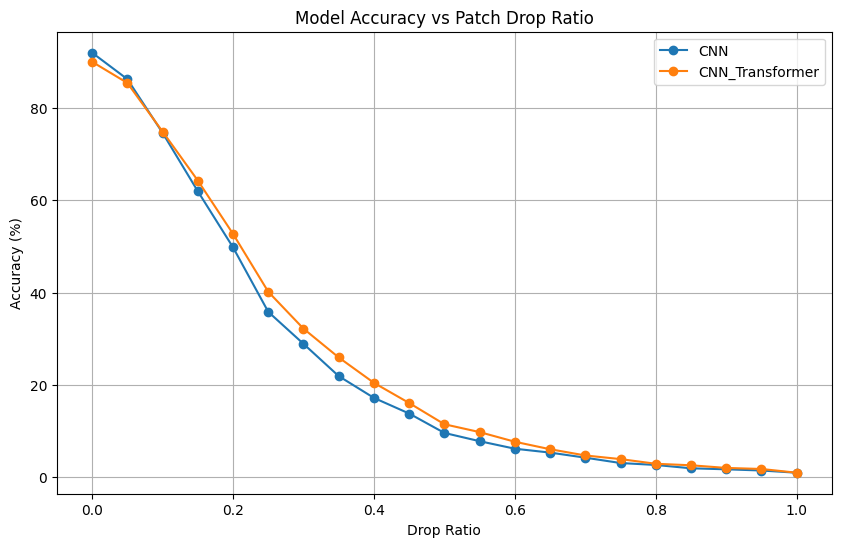

In [22]:
drop_ratios = [round(x * 0.05, 2) for x in range(0, 21)]
compare_models_patch_drop([cnn, hybrid], ['CNN', 'CNN_Transformer'], valid_loader, DEVICE, drop_ratios)